In [2]:
cd "/suphys/aloe8475"


/suphys/aloe8475


In [3]:
cd "Documents/edamame"

/import/silo2/aloe8475/Documents/edamame


In [4]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook
import os
import edamame.core.wires as wires
from random import choice
import warnings
from IPython.core.debugger import set_trace
import nct
import bct

#warnings.filterwarnings('ignore')

In [5]:
import pickle 
import _pickle as cPickle
import gzip
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)

In [6]:
# this_seed2=700
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [7]:
#Select Largest Components
def select_largest_component_new(wires_dict):
    """
    Find and select largest connected component of the original graph G.
    Throws away unconnected components and updates all the keys in wires_dict 
    """
#     def connected_component_subgraphs(G):
#         for c in nx.connected_components(G):
#             yield G.subgraph(c)
    
    wires_dict['G'] = max(connected_component_subgraphs(wires_dict['G']), key=len)
#     set_trace()
    nw = len(wires_dict['G'].nodes())
    nj = len(wires_dict['G'].edges())   
    
    logging.info("The largest component has %5d nodes and %6d edges", nw, nj)

    # Replace values in the dictionary
    wires_dict['number_of_wires']     = nw
    wires_dict['number_of_junctions'] = nj
    wires_dict['xa'] = wires_dict['xa'][wires_dict['G'].nodes()] 
    wires_dict['ya'] = wires_dict['ya'][wires_dict['G'].nodes()] 
    wires_dict['xb'] = wires_dict['xb'][wires_dict['G'].nodes()] 
    wires_dict['yb'] = wires_dict['yb'][wires_dict['G'].nodes()]
    wires_dict['xc'] = wires_dict['xc'][wires_dict['G'].nodes()] 
    wires_dict['yc'] = wires_dict['yc'][wires_dict['G'].nodes()]
 
    # Keep old edge_list
    old_edge_list = [(ii, kk) for ii, kk in  zip(wires_dict['edge_list'][:, 0], wires_dict['edge_list'][:, 1])]
    # Remove old edge list
    wires_dict = wires.remove_key(wires_dict, 'edge_list') 
    # Save indices of intersections in the old graph
    ind_dict = {key:value for value,key in enumerate(old_edge_list)}
    new_edge_list = sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0])
    # Find intersection between the two sets
    inter = set(ind_dict).intersection(new_edge_list)
    # Retrieve edge indices/positions from the old list
    edges_idx = [ind_dict[idx] for idx in inter]
       
    # These have length equal to number of junctions -- only get the ones we need
    wires_dict['xi'] = wires_dict['xi'][edges_idx] 
    wires_dict['yi'] = wires_dict['yi'][edges_idx] 
    
    # Get contiguous numbering of nodes
    # Build node mapping 
    node_mapping    = {key:value for value, key in enumerate(sorted(wires_dict['G'].nodes()))}
    # This  step also renames edges list
    wires_dict['G'] =  nx.relabel_nodes(wires_dict['G'] , node_mapping)

    # Swap node vertices if vertex 0 is larger than vertex 1, then sort by first element
    wires_dict['edge_list'] = np.asarray(sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0]))
    
    # Save adjacency matrix of new graph
    wires_dict = wires.remove_key(wires_dict, 'adj_matrix') 
    wires_dict = wires.generate_adj_matrix(wires_dict)

    wire_distances = wires.cdist(np.array([wires_dict['xc'], wires_dict['yc']]).T, np.array([wires_dict['xc'], wires_dict['yc']]).T, metric='euclidean')    
    wires_dict['wire_distances'] = wire_distances

    return wires_dict 

In [8]:
cd "/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/"

/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks


In [9]:
data=loadmat('avgDegreeVals_allASN.mat')
avgDeg=data['avgdeg'][0]

numNodes=data['numNodes'][0]

In [10]:
ResultSqu_Grid=[None]*len(avgDeg)
ResultSqu_Random=[None]*len(avgDeg)

In [11]:
name='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/WS_Allnetworks_LinearTransformation.pkl'
if (os.path.isfile(name)): #if we haven't saved the file
    print('Loading WS')
    file = open(name, 'rb')
    [WS_Grid,WS_Random] = pickle.load(file)
    print('Loaded')
else:
    print('WS Analysis has not been done')

Loading WS
Loaded


In [12]:
numRand=3
if (not os.path.isfile(name)): #if we haven't saved the file
#get seed from previous networks:
    name='WS_Allnetworks_LinearTransformation.pkl'
    file = open(name, 'rb')
    #     [ASN300,cluster1,cluster2,cluster3,time_index,nodesList] = pickle.load(file)
    #     [ASN300,cluster1,cluster2,cluster3] = pickle.load(file)
    [WS_Grid,WS_Random] = pickle.load(file)
    seed=[]

    seed2=[[None]*numRand for i in range(len(WS_Random))]
    for i in range(len(WS_Random)):
        for j in range(numRand):
            if j == 0:
                seed2[i][j]=(WS_Random[i][j]['seed'])
            else:
                seed2[i][j]=np.random.randint(10000)

In [13]:
if (not os.path.isfile(name)): #if we haven't saved the file

    #create watts strogatz graphs:
    random=[[None]*3 for i in range(len(WS_Random))]
    temp2=[[None]*numRand for i in range(len(WS_Random))]
    grid=[]
    temp=[]
    for i in range(len(avgDeg)):
        k=int(np.round(avgDeg[i]))

        #loop 3 times with different random seed
        for j in range(numRand):
            temp2[i][j]=(nx.watts_strogatz_graph(numNodes[i],2*k,1,seed=seed2[i][j]))
            random[i][j]=(max(connected_component_subgraphs(temp2[i][j]), key=len))     

    temp.append(nx.watts_strogatz_graph(300,4,0,seed=seed2[0][0])) #proper grid (avg degree = 2)
        #     temp.append(nx.watts_strogatz_graph(numNodes[i],2*k,0,seed=seed[i])) #ring lattice with k avg degree
    grid.append(max(connected_component_subgraphs(temp[0]), key=len))
else:
    random=[[None]*3 for i in range(len(WS_Random))]
    for i in range(len(avgDeg)):
        for j in range(numRand):
            random[i][j]=WS_Random[i][j]['G']
    grid=WS_Grid['G']

In [14]:
# nx.draw(grid[0],pos=nx.kamada_kawai_layout(grid[0]),node_size=5)
# nx.draw_networkx_edges(grid[0],pos=nx.kamada_kawai_layout(grid[0]))

In [16]:
temp_rand=[[None]*3 for i in range(len(WS_Random))]
temp=[]
shortestPath_Grid=[]
shortestPath_Random=[[None]*3 for i in range(len(WS_Random))]
onAmp_Grid=[]
onAmp_Random=[[None]*3 for i in range(len(WS_Random))]

for i in tqdm(range(len(avgDeg))):
    for j in range(numRand):
        temp_rand[i][j]=(getFarthestPairing(nx.adj_matrix(random[i][j]).todense()))
        shortestPath_Random[i][j]=(nx.shortest_path_length(random[i][j],temp_rand[i][j][0],temp_rand[i][j][1]))
        onAmp_Random[i][j]=(shortestPath_Random[i][j]/5)
        
temp.append(getFarthestPairing(nx.adj_matrix(grid[0]).todense()))
shortestPath_Grid.append(nx.shortest_path_length(grid[0],temp[0][0],temp[0][1]))
onAmp_Grid.append(shortestPath_Grid[0]/5)

In [17]:
# seed[105]=np.random.randint(10000)

In [18]:
if (not os.path.isfile(name)): #if we haven't saved the file

    WS_Grid=[]
    WS_Random=[[None]*numRand for i in range(len(avgDeg))]
    for i in range(len(avgDeg)):
        for j in range(numRand):
            WS_Random[i][j]={'seed':[],'adj_matrix':[],'G':[],'Accuracy':{'Linear Transformation':[],'Mackey Glass':[],'MNIST':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}}
    WS_Grid={'seed':[],'adj_matrix':[],'G':[],'Accuracy':{'Linear Transformation':[],'Mackey Glass':[],'MNIST':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}}

In [19]:
# WS:
if (not os.path.isfile(name)): #if we haven't saved the file
    WS_Grid['seed']=seed
    WS_Grid['sp_amp']=onAmp_Grid
    for i in tqdm(range(len(WS_Random))):
        for j in range(numRand):
            WS_Random[i][j]['seed']=seed2[i][j]
            WS_Random[i][j]['sp_amp']=onAmp_Random[i][j]
    name='WS_Allnetworks_LinearTransformation.pkl'
    print('Saving WS')
    with open(name, 'wb') as f:
        pickle.dump([WS_Grid,WS_Random], f)   

In [20]:
def WS_Run(grid,random,onAmp_Grid,onAmp_Random,nodesList,nodesList_Grid,WS_Grid,WS_Random,i):
    stimulus=[[],[]]
    stimulus_Rand=[[[],[]] for j in range(len(random[0]))]
    stimulus2_Rand=[None]*len(random[0])
    results_rand=[]
    nwSqu_Random=[]
    dt = 1e-2
    f=0.5
    Time=5
    stimulus[0]=(stimulus__(biasType='AC',onAmp=onAmp_Grid[0],TimeVector=np.arange(0,Time,dt),f=f))
    stimulus[1]=(stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt))) #we don't want this drain to be active during training
    for j in range(len(random[0])):
        stimulus_Rand[j][0]=(stimulus__(biasType='AC',onAmp=onAmp_Random[i][j],TimeVector=np.arange(0,Time,dt),f=f))
        stimulus_Rand[j][1]=(stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt))) #we don't want this drain to be active during training
        stimulus2_Rand[j]=[item for item in stimulus_Rand[j]]
        
    stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item

    results_grid=(runSim(connectivity__(graph=grid[0]),stimulus=stimulus2, contactMode='farthest', T = Time, dt = dt, onAmp = onAmp_Grid[0], biasType='AC',f=f,junctionMode='tunneling'))
    conductance=[]
    for j in range(len(random[0])):
        results_rand.append(runSim(connectivity__(graph=random[i][j]),stimulus=stimulus2_Rand[j], contactMode='farthest', T = Time, dt = dt, onAmp = onAmp_Random[i][j], biasType='AC',f=f,junctionMode='tunneling'))
        nwSqu_Random.append([None]*len(nodesList[j][i]))
        conductance.append(results_rand[j].conductance)
    nwSqu_Grid=[None]*len(nodesList_Grid)
    
    for j in range(len(random[0])):
        countk=0
        for k in nodesList[j][i]: #loop through sets of nodes for regression
            print('Running Random Network Regression: ' + str(k) + ' nodes')
            ResultSqu_Random=[]
            ResultSqu_Random= nonLinearTrans(results_rand[j],'Square',k, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
            nwSqu_Random[j][countk]=(ResultSqu_Random['accuracy'])
            countk=countk+1
            if k == nodesList[j][i][-1]: #if k is equal to the largest node sampling
                WS_Random[i][j]['Accuracy']['Linear Transformation']=[]
                WS_Random[i][j]['Accuracy']['Linear Transformation'].append(nwSqu_Random[j])
    #             print(WS_Random[i]['Accuracy']['Linear Transformation'])
            else:
                WS_Random[i][j]['Accuracy']['Linear Transformation']=[None]
    countk=0
    
    for k in nodesList_Grid:     
        print('Running Grid Network Regression: ' + str(k) + ' nodes')
        ResultSqu_Grid=[]
        ResultSqu_Grid = nonLinearTrans(results_grid,'Square',k, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
        nwSqu_Grid[countk]=(ResultSqu_Grid['accuracy'])
        countk=countk+1
        if k == nodesList[0][i][-1]: #if k is equal to the largest node sampling
            WS_Grid['Accuracy']['Linear Transformation']=[]
            WS_Grid['Accuracy']['Linear Transformation'].append(nwSqu_Grid)
#             print(WS_Grid[i]['Accuracy']['Linear Transformation'])
        else:
            WS_Grid['Accuracy']['Linear Transformation']=[None]
    
    accGrid=nwSqu_Grid
    accRandom=nwSqu_Random
    
    name= r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/conductance_RandomNonLinearTransformation_'+str(i)
    compressed_pickle([conductance],name)
    return accGrid,accRandom,WS_Grid,WS_Random

In [21]:
nodesList=[[None]*len(avgDeg) for i in range(numRand)]
for i in tqdm(range(len(avgDeg))):
    for j in range(numRand): #grid, random
        if len(random[i][j]) >= 250:
            nodesList[j][i]=[50,100,150,200,250,len(random[i][j])]#range(50, len(ws300[i][0])+1,50)
        elif len(random[i][j]) >= 200 and len(random[i][j]) < 250:
            nodesList[j][i]=[50,100,150,200,len(random[i][j])]#range(50, len(ws300[i][0])+1,50)  
        elif len(random[i][j]) >= 150 and len(random[i][j]) < 200:
            nodesList[j][i]=[50,100,150,len(random[i][j])]#range(50, len(ws300[i][0])+1,50)  
        elif len(random[i][j]) >= 100 and len(random[i][j]) < 150:
            nodesList[j][i]=[50,100,len(random[i][j])]#range(50, len(ws300[i][0])+1,50)

if len(grid[0]) >= 250:
    nodesList_Grid=[50,100,150,200,250,len(grid[0])]#range(50, len(ws300[i][0])+1,50)
elif len(grid[0]) >= 200 and len(grid[0]) < 250:
    nodesList_Grid=[50,100,150,200,len(grid[0])]#range(50, len(ws300[i][0])+1,50)  
elif len(grid[0]) >= 150 and len(grid[0]) < 200:
    nodesList_Grid=[50,100,150,len(grid[0])]#range(50, len(ws300[i][0])+1,50)  
elif len(grid[0]) >= 100 and len(grid[0]) < 150:
    nodesList_Grid=[50,100,len(grid[0])]#range(50, len(ws300[i][0])+1,50)

In [22]:
if ( os.path.isfile(name)): #if we haven't saved the file

    # results_grid=[]
    # results_rand=[]
    init=[]
    for i in range(len(avgDeg)):
       init.append(inputPacker(WS_Run,grid,random,onAmp_Grid,onAmp_Random,nodesList,nodesList_Grid,WS_Grid,WS_Random,i))

In [23]:
if ( os.path.isfile(name)): #if we haven't saved the file

    #### parallel run simulations
    result=para_run(WS_Run,init,nCPU=10)

2020-06-22 16:03:10,487:INFO:First current path [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150] formed at time = 0.75 s.


2020-06-22 16:03:12,262:INFO:First current path [0, 23, 48, 16] formed at time = 0.75 s.


2020-06-22 16:03:13,980:INFO:First current path [0, 84, 51, 3] formed at time = 0.75 s.


2020-06-22 16:03:15,691:INFO:First current path [0, 89, 26, 6] formed at time = 0.75 s.


Running Random Network Regression: 50 nodes
Running Random Network Regression: 100 nodes
Running Random Network Regression: 150 nodes
Running Random Network Regression: 200 nodes
Running Random Network Regression: 250 nodes
Running Random Network Regression: 299 nodes
Running Random Network Regression: 50 nodes
Running Random Network Regression: 100 nodes
Running Random Network Regression: 150 nodes
Running Random Network Regression: 200 nodes
Running Random Network Regression: 250 nodes
Running Random Network Regression: 299 nodes
Running Random Network Regression: 50 nodes
Running Random Network Regression: 100 nodes
Running Random Network Regression: 150 nodes
Running Random Network Regression: 200 nodes


2020-06-22 16:03:23,040:INFO:First current path [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150] formed at time = 0.75 s.


Running Random Network Regression: 250 nodes
Running Random Network Regression: 299 nodes


2020-06-22 16:03:25,325:INFO:First current path [0, 44, 133, 18] formed at time = 0.75 s.


Running Grid Network Regression: 50 nodes


Running Grid Network Regression: 100 nodes
Running Grid Network Regression: 150 nodes
Running Grid Network Regression: 200 nodes
Running Grid Network Regression: 250 nodes
Running Grid Network Regression: 300 nodes


2020-06-22 16:03:27,375:INFO:First current path [0, 1, 87, 9] formed at time = 0.75 s.


2020-06-22 16:03:29,423:INFO:First current path [0, 75, 290, 47] formed at time = 0.75 s.


Running Random Network Regression: 50 nodes
Running Random Network Regression: 100 nodes
Running Random Network Regression: 150 nodes
Running Random Network Regression: 200 nodes
Running Random Network Regression: 250 nodes
Running Random Network Regression: 300 nodes
Running Random Network Regression: 50 nodes
Running Random Network Regression: 100 nodes


AttributeError: 'list' object has no attribute 'conductance'

In [43]:
if (not os.path.isfile(name)): #if we haven't saved the file

    for i in range(len(result)):
        for j in range(numRand):
            WS_Random[i][j]['Accuracy']['Linear Transformation']=[ii[1] for ii in result][i][j]
    WS_Grid['Accuracy']['Linear Transformation']=[ii[0] for ii in result][i]


In [44]:
if (not os.path.isfile(name)): #if we haven't saved the file
    #export adj matrices to calculate small worldness in matlab:
    adj_mats={"AdjMat_Grid":[],"AdjMat_Random":[]}
    for i in tqdm(range(len(WS_Random))):
        for j in range(numRand):
            adj_mats['AdjMat_Random'].append(dict(random=nx.adj_matrix(random[i][j]).todense()))
            WS_Random[i][j]['adj_matrix']=nx.adj_matrix(random[i][j]).todense()

    adj_mats['AdjMat_Grid']=(dict(grid=nx.adj_matrix(grid[0]).todense()))
    WS_Grid['adj_matrix']=nx.adj_matrix(grid[0]).todense()

    savemat('/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300_WS_AllASN.mat',adj_mats)

In [45]:
cd "/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/"

/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity


In [46]:
smallworld_ws={'Grid':[],'Random':[]}
# temp=loadmat(r'300_WS_smallworld.mat')
temp=loadmat(r'300_WS_AllASN_smallworld.mat')
smallworld_ws['Grid']=temp['smallworld_grid']
smallworld_ws['Random']=temp['smallworld_random']
del temp

In [47]:
smallworld_ws['Grid']

array([[0.29289322]])

In [48]:
cd "/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/"

/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks


In [49]:
smallworld_ws['Random']=smallworld_ws['Random'].reshape(300,3)

In [50]:
if (not os.path.isfile(name)): #if we haven't saved the file
    # WS:
    ci = []
    pcoeff= []
    mz= []
    clustering = []
    ci,q=nct.community_louvain(np.squeeze(np.asarray(WS_Grid['adj_matrix'])))
    pcoeff=bct.participation_coef(np.squeeze(np.asarray(WS_Grid['adj_matrix'])),ci)
    mz=bct.module_degree_zscore(np.squeeze(np.asarray(WS_Grid['adj_matrix'])),ci)
    WS_Grid['G']=grid
    clustering=nx.clustering(WS_Grid['G'][0])
    WS_Grid['Graph Theory']['PL']=dict(nx.all_pairs_shortest_path_length(WS_Grid['G'][0]))
    WS_Grid['Graph Theory']['Modularity']=ci
    WS_Grid['Graph Theory']['Modularity Score']=q
    WS_Grid['Graph Theory']['PCoeff']=pcoeff
    WS_Grid['Graph Theory']['MZ']=mz
    WS_Grid['Graph Theory']['Small World']=smallworld_ws['Grid'][0][0]
    WS_Grid['Graph Theory']['CCoeff']=clustering
    WS_Grid['Graph Theory']['Degree']=nx.degree(WS_Grid['G'][0])
    WS_Grid['Graph Theory']['AvgPL']=nx.average_shortest_path_length(WS_Grid['G'][0])

    ci = []
    pcoeff= []
    mz= []
    clustering = []
    count1=0
    count2=0
    count3=0   
    for i in tqdm(range(len(WS_Random))):
        for j in range(numRand):
            ci,q=nct.community_louvain(np.squeeze(np.asarray(WS_Random[i][j]['adj_matrix'])))
            pcoeff=bct.participation_coef(np.squeeze(np.asarray(WS_Random[i][j]['adj_matrix'])),ci)
            mz=bct.module_degree_zscore(np.squeeze(np.asarray(WS_Random[i][j]['adj_matrix'])),ci)
            WS_Random[i][j]['G']=random[i][j]
            clustering=nx.clustering(WS_Random[i][j]['G'])
            WS_Random[i][j]['Graph Theory']['PL']=dict(nx.all_pairs_shortest_path_length(WS_Random[i][j]['G']))
            WS_Random[i][j]['Graph Theory']['Modularity']=ci
            WS_Random[i][j]['Graph Theory']['Modularity Score']=q
            WS_Random[i][j]['Graph Theory']['PCoeff']=pcoeff
            WS_Random[i][j]['Graph Theory']['MZ']=mz
            WS_Random[i][j]['Graph Theory']['Small World']=smallworld_ws['Random'][i][j]
            WS_Random[i][j]['Graph Theory']['CCoeff']=clustering
            WS_Random[i][j]['Graph Theory']['Degree']=nx.degree(WS_Random[i][j]['G'])
            WS_Random[i][j]['Graph Theory']['AvgPL']=nx.average_shortest_path_length(WS_Random[i][j]['G'])    

    name='WS_Allnetworks_LinearTransformation.pkl'
    print('Saving WS')
    with open(name, 'wb') as f:
        pickle.dump([WS_Grid,WS_Random], f) 

# Scale-Free Barabasi-Albert Networks:

In [51]:
BA_scaleFree=[None]*len(avgDeg)
for i in range(len(avgDeg)):
    BA_scaleFree[i]={'seed':[],'adj_matrix':[],'G':[],'Accuracy':{'Linear Transformation':[],'Mackey Glass':[],'MNIST':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}}

In [75]:
temp=[]
scaleFree=[]
for i in range(len(avgDeg)):
    k=int(np.round(avgDeg[i]))
    temp.append(nx.barabasi_albert_graph(numNodes[i],k,seed=WS_Random[i][0]['seed']))
    scaleFree.append(max(connected_component_subgraphs(temp[i]), key=len))

In [97]:
temp=[]
shortestPath_BA=[]
onAmp_BA=[]

for i in tqdm(range(len(avgDeg))):
    temp.append(getFarthestPairing(nx.adj_matrix(scaleFree[i]).todense()))
    shortestPath_BA.append(nx.shortest_path_length(scaleFree[i],temp[i][0],temp[i][1]))
    onAmp_BA.append(shortestPath_BA[i]/5)

In [99]:
# WS:
for i in tqdm(range(len(BA_scaleFree))):
    BA_scaleFree[i]['seed']=WS_Random[i][0]['seed']
    BA_scaleFree[i]['sp_amp']=onAmp_BA[i]
name='BA_Allnetworks_LinearTransformation.pkl'
print('Saving BA')
with open(name, 'wb') as f:
    pickle.dump([BA_scaleFree], f)   
print('Finished Saving')


Saving BA
Finished Saving


In [100]:
nodesList=[None]*len(avgDeg)
for i in tqdm(range(len(avgDeg))):
    if len(scaleFree[i]) >= 250:
        nodesList[i]=[50,100,150,200,250,len(scaleFree[i])]#range(50, len(ws300[i][0])+1,50)
    elif len(scaleFree[i]) >= 200 and len(scaleFree[i]) < 250:
        nodesList[i]=[50,100,150,200,len(scaleFree[i])]#range(50, len(ws300[i][0])+1,50)  
    elif len(scaleFree[i]) >= 150 and len(scaleFree[i]) < 200:
        nodesList[i]=[50,100,150,len(scaleFree[i])]#range(50, len(ws300[i][0])+1,50)  
    elif len(scaleFree[i]) >= 100 and len(scaleFree[i]) < 150:
        nodesList[i]=[50,100,len(scaleFree[i])]#range(50, len(ws300[i][0])+1,50)

In [101]:
def BA_Run(graph,onAmp,nodesList,network,i):
    stimulus=[[],[]]
    dt = 1e-2
    f=0.5
    Time=5
    stimulus[0]=(stimulus__(biasType='AC',onAmp=onAmp[i],TimeVector=np.arange(0,Time,dt),f=f))
    stimulus[1]=(stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt))) #we don't want this drain to be active during training

    stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item

    results_grid=(runSim(connectivity__(graph=graph[i]),stimulus=stimulus2, contactMode='farthest', T = Time, dt = dt, onAmp = onAmp[i], biasType='AC',f=f,junctionMode='tunneling'))
#     period=1/f
    
    nwSqu=[None]*len(nodesList[i])
    countk=0
    for k in nodesList[i]: #loop through sets of nodes for regression     
        print('Running BA Network Regression: ' + str(k) + ' nodes')
        ResultSqu=[]
        ResultSqu = nonLinearTrans(results_grid,'Square',k, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
        nwSqu[countk]=(ResultSqu['accuracy'])
        countk=countk+1
        if k == nodesList[i][-1]: #if k is equal to the largest node sampling
            network[i]['Accuracy']['Linear Transformation']=[]
            network[i]['Accuracy']['Linear Transformation'].append(nwSqu)
#             print(WS_Grid[i]['Accuracy']['Linear Transformation'])
        else:
            network[i]['Accuracy']['Linear Transformation']=[None]
    
    accNetwork=nwSqu
    return accNetwork,network

In [102]:
# results_grid=[]
# results_rand=[]
init=[]
for i in range(len(avgDeg)):
   init.append(inputPacker(BA_Run,scaleFree,onAmp_BA,nodesList,BA_scaleFree,i))

In [103]:
#### parallel run simulations
result=para_run(BA_Run,init,nCPU=10)


2020-06-17 14:43:41,499:INFO:First current path [250, 103, 240, 222, 293] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:43:42,838:INFO:First current path [1, 59, 239, 112] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:43:43,020:INFO:First current path [0, 23, 160, 254] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:43:44,275:INFO:First current path [14, 66, 242, 216] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:43:45,137:INFO:First current path [176, 191, 287, 210] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


2020-06-17 14:43:45,153:INFO:First current path [280, 273, 231, 277] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:43:45,460:INFO:First current path [0, 44, 2] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:43:47,006:INFO:First current path [0, 56, 2] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:43:47,058:INFO:First current path [0, 52, 2] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:43:47,117:INFO:First current path [105, 65, 123, 124, 290] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:43:47,514:INFO:First current path [0, 65, 2] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:43:48,305:INFO:First current path [0, 92, 62, 231] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:43:49,114:INFO:First current path [1, 219, 108, 148] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 298 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:43:50,164:INFO:First current path [3, 85, 181, 161] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 250 nodes


Running BA Network Regression: 300 nodes


2020-06-17 14:43:53,092:INFO:First current path [0, 69, 285, 299] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:43:53,984:INFO:First current path [220, 164, 277, 272] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:43:54,156:INFO:First current path [273, 195, 183, 286] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:43:54,619:INFO:First current path [22, 205, 142, 199] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:43:56,361:INFO:First current path [3, 85, 31, 213, 209] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:43:56,587:INFO:First current path [0, 47, 2] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:43:56,863:INFO:First current path [0, 50, 2] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:43:57,276:INFO:First current path [173, 199, 30, 25, 263] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 292 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:43:58,796:INFO:First current path [1, 92, 192, 296] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:43:58,963:INFO:First current path [3, 132, 148, 153] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:43:59,400:INFO:First current path [0, 10, 130, 79] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:00,079:INFO:First current path [69, 93, 251, 299] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:00,835:INFO:First current path [132, 182, 230, 223] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:01,323:INFO:First current path [160, 204, 238, 278] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:02,032:INFO:First current path [0, 40, 2] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:02,688:INFO:First current path [0, 44, 2] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:44:03,680:INFO:First current path [165, 74, 22, 169, 148, 288] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:44:04,466:INFO:First current path [0, 8, 24, 129, 174] formed at time = 0.83 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 295 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:05,795:INFO:First current path [0, 18, 296, 89] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 299 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:44:07,183:INFO:First current path [0, 138, 129, 238] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes


2020-06-17 14:44:07,614:INFO:First current path [2, 139, 282, 247] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:44:07,839:INFO:First current path [4, 81, 216, 229] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 297 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:08,752:INFO:First current path [4, 291, 55, 195] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:09,277:INFO:First current path [7, 148, 188, 103] formed at time = 0.79 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:44:09,517:INFO:First current path [261, 166, 255, 112, 107, 230] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 299 nodes


2020-06-17 14:44:09,715:INFO:First current path [147, 26, 280, 290] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:10,383:INFO:First current path [23, 72, 268, 122, 260] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:10,499:INFO:First current path [223, 52, 219, 297] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:11,109:INFO:First current path [126, 227, 122, 125, 179] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 279 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 294 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:44:12,705:INFO:First current path [0, 11, 122, 110] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 299 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:44:13,447:INFO:First current path [0, 61, 228, 242] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:14,125:INFO:First current path [0, 146, 267, 206] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:44:14,711:INFO:First current path [2, 214, 297, 252] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:16,101:INFO:First current path [7, 79, 160, 278] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:16,441:INFO:First current path [2, 131, 74, 244] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:16,770:INFO:First current path [9, 234, 283, 216] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:17,323:INFO:First current path [277, 190, 29, 294, 224, 288] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:17,782:INFO:First current path [60, 36, 28, 273, 158, 280] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 295 nodes
Running BA Network Regression: 281 nodes


2020-06-17 14:44:19,754:INFO:First current path [227, 124, 15, 252, 278] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:20,129:INFO:First current path [2, 6, 4, 154, 206] formed at time = 0.88 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:20,564:INFO:First current path [275, 180, 91, 93, 242] formed at time = 0.79 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:21,444:INFO:First current path [0, 37, 236, 276] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes


Running BA Network Regression: 299 nodes


Running BA Network Regression: 298 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:44:23,586:INFO:First current path [5, 50, 223, 122] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


2020-06-17 14:44:23,610:INFO:First current path [2, 74, 288, 238] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:44:23,849:INFO:First current path [9, 45, 116, 260] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:44:27,146:INFO:First current path [4, 72, 274, 221] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:28,023:INFO:First current path [268, 103, 13, 93, 146, 212] formed at time = 0.79 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:28,360:INFO:First current path [208, 145, 30, 4, 215, 103, 125, 237] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:44:28,581:INFO:First current path [29, 59, 8, 113, 230] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:29,902:INFO:First current path [0, 28, 117, 168] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 293 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 278 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 294 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:44:31,514:INFO:First current path [169, 45, 15, 135, 264] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:31,898:INFO:First current path [0, 186, 173, 238] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 298 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:32,334:INFO:First current path [0, 14, 201, 268] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:32,670:INFO:First current path [0, 38, 299, 214] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:44:32,777:INFO:First current path [1, 272, 166, 129] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 296 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:34,288:INFO:First current path [0, 68, 281, 298] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:44:34,410:INFO:First current path [57, 19, 263, 237, 240, 253] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:35,433:INFO:First current path [61, 41, 48, 104, 160] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:36,196:INFO:First current path [145, 207, 97, 170, 284] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 286 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:44:36,429:INFO:First current path [231, 184, 40, 291, 295] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:44:36,834:INFO:First current path [242, 206, 0, 54, 209] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 291 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:37,609:INFO:First current path [0, 132, 176, 248] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 296 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:38,234:INFO:First current path [0, 213, 117, 247] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 297 nodes


2020-06-17 14:44:39,944:INFO:First current path [0, 16, 160, 265] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:44:40,053:INFO:First current path [1, 189, 97, 68] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:40,657:INFO:First current path [53, 33, 183, 46, 163, 179] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:41,034:INFO:First current path [89, 43, 0, 86, 114, 175] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:41,340:INFO:First current path [177, 89, 0, 78, 155, 239] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 285 nodes


2020-06-17 14:44:42,912:INFO:First current path [23, 291, 182, 136, 270] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 280 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 293 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:44:43,929:INFO:First current path [95, 86, 20, 144, 289] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 250 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 298 nodes


2020-06-17 14:44:44,889:INFO:First current path [227, 124, 61, 180, 295] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


2020-06-17 14:44:44,961:INFO:First current path [0, 12, 292, 170] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:45,631:INFO:First current path [0, 38, 253, 90] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes


2020-06-17 14:44:45,661:INFO:First current path [0, 40, 210, 263] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:44:47,008:INFO:First current path [79, 21, 42, 46, 26, 157, 241] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 300 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:47,381:INFO:First current path [2, 36, 65, 295] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:48,274:INFO:First current path [49, 22, 4, 23, 169, 174] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


2020-06-17 14:44:48,282:INFO:First current path [261, 48, 38, 25, 117, 195] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 279 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:49,064:INFO:First current path [231, 217, 25, 13, 152, 257] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes


2020-06-17 14:44:49,138:INFO:First current path [85, 114, 0, 155, 215] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 285 nodes


Running BA Network Regression: 295 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:50,220:INFO:First current path [94, 76, 54, 182, 253] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 285 nodes


2020-06-17 14:44:50,998:INFO:First current path [251, 102, 76, 258, 289] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 295 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:51,542:INFO:First current path [0, 19, 182, 115] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:44:52,962:INFO:First current path [1, 114, 172, 158] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes


2020-06-17 14:44:52,964:INFO:First current path [68, 174, 19, 18, 30, 257] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:53,900:INFO:First current path [0, 15, 209, 235] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:54,376:INFO:First current path [0, 182, 203, 77] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 279 nodes


2020-06-17 14:44:55,030:INFO:First current path [49, 223, 11, 114, 225] formed at time = 0.77 s.


Running BA Network Regression: 200 nodes
Running BA Network Regression: 50 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:44:55,143:INFO:First current path [0, 14, 187, 206] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 250 nodes


Running BA Network Regression: 296 nodes


2020-06-17 14:44:56,693:INFO:First current path [37, 2, 5, 261, 215] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 299 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:57,541:INFO:First current path [196, 83, 69, 90, 271, 262] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:44:57,761:INFO:First current path [60, 11, 4, 114, 240, 274] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:44:58,137:INFO:First current path [28, 62, 42, 44, 143, 158] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:58,530:INFO:First current path [51, 26, 23, 12, 198, 257] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 293 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:59,059:INFO:First current path [87, 16, 50, 0, 114, 170, 223] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:44:59,460:INFO:First current path [0, 12, 235, 124] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 289 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 297 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 282 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 279 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 277 nodes


2020-06-17 14:45:01,164:INFO:First current path [0, 24, 88, 237] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:45:01,715:INFO:First current path [0, 120, 77, 67] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:02,750:INFO:First current path [59, 127, 23, 154, 210] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 294 nodes


2020-06-17 14:45:03,293:INFO:First current path [29, 122, 102, 284, 263] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:45:03,927:INFO:First current path [280, 113, 27, 272, 245, 277] formed at time = 0.79 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:04,290:INFO:First current path [173, 121, 24, 115, 76, 169] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 299 nodes


2020-06-17 14:45:04,828:INFO:First current path [57, 14, 4, 95, 252, 269] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 297 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:05,349:INFO:First current path [42, 23, 24, 2, 125, 179, 227] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 295 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 288 nodes


2020-06-17 14:45:06,323:INFO:First current path [1, 48, 230, 131] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes


Running BA Network Regression: 283 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 280 nodes


2020-06-17 14:45:07,421:INFO:First current path [0, 194, 289, 209] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:07,996:INFO:First current path [235, 164, 21, 151, 293] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes


2020-06-17 14:45:08,002:INFO:First current path [101, 75, 22, 60, 262] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 299 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:45:09,808:INFO:First current path [86, 65, 90, 50, 228] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:45:10,047:INFO:First current path [36, 17, 37, 236, 269] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:45:11,040:INFO:First current path [288, 268, 211, 4, 181, 216] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:11,505:INFO:First current path [279, 150, 97, 40, 134, 238] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 296 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:11,834:INFO:First current path [57, 29, 10, 21, 58, 244] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 297 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:12,230:INFO:First current path [77, 30, 34, 75, 137, 258] formed at time = 0.79 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 292 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 286 nodes


2020-06-17 14:45:13,511:INFO:First current path [0, 65, 136, 122] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 283 nodes


Running BA Network Regression: 150 nodes


2020-06-17 14:45:13,930:INFO:First current path [187, 98, 219, 251, 276] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 279 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:45:14,666:INFO:First current path [0, 14, 146, 211] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:15,144:INFO:First current path [270, 37, 144, 260, 215] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:15,871:INFO:First current path [62, 101, 23, 187, 197] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 298 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:45:16,123:INFO:First current path [25, 6, 0, 168, 207] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:45:16,880:INFO:First current path [29, 59, 170, 138, 272] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 296 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 200 nodes


Running BA Network Regression: 298 nodes


2020-06-17 14:45:17,903:INFO:First current path [49, 205, 3, 9, 209, 248] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 292 nodes


2020-06-17 14:45:18,126:INFO:First current path [93, 66, 6, 16, 181, 269] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 282 nodes


2020-06-17 14:45:18,916:INFO:First current path [0, 51, 77, 72] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:18,968:INFO:First current path [61, 118, 119, 41, 217, 220] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 287 nodes


Running BA Network Regression: 283 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:45:20,466:INFO:First current path [188, 222, 70, 149, 223] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes


2020-06-17 14:45:20,747:INFO:First current path [249, 225, 9, 98, 284] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 284 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:45:21,216:INFO:First current path [5, 240, 3, 56, 273] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:21,566:INFO:First current path [0, 65, 298, 149] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:21,848:INFO:First current path [24, 22, 18, 158, 286] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:45:22,343:INFO:First current path [274, 182, 159, 33, 111, 237] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 298 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:22,883:INFO:First current path [237, 180, 69, 82, 167, 207] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 298 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:45:23,460:INFO:First current path [45, 236, 21, 146, 164, 255] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 294 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:23,977:INFO:First current path [78, 74, 10, 0, 43, 101, 225] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 292 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 279 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:25,277:INFO:First current path [57, 224, 45, 25, 61, 133, 264] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 289 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 281 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:45:26,595:INFO:First current path [0, 17, 181, 232] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 279 nodes


2020-06-17 14:45:27,007:INFO:First current path [0, 11, 146, 161] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:45:27,634:INFO:First current path [62, 70, 22, 207, 158] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:45:28,312:INFO:First current path [40, 185, 3, 103, 205] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:45:29,120:INFO:First current path [12, 168, 40, 66, 267] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 297 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:45:29,806:INFO:First current path [205, 66, 190, 177, 150, 275] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:45:30,356:INFO:First current path [65, 35, 5, 57, 111, 262] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:45:30,414:INFO:First current path [98, 44, 5, 118, 179, 204] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 294 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 292 nodes


2020-06-17 14:45:31,711:INFO:First current path [0, 246, 254, 180] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 279 nodes


2020-06-17 14:45:32,202:INFO:First current path [172, 97, 54, 286, 185] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 279 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 150 nodes


2020-06-17 14:45:32,524:INFO:First current path [198, 257, 26, 49, 277] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:32,899:INFO:First current path [0, 175, 60, 147, 218] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:45:33,778:INFO:First current path [116, 135, 7, 179, 291] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 297 nodes


2020-06-17 14:45:34,221:INFO:First current path [3, 107, 42, 95, 274] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:34,499:INFO:First current path [222, 76, 34, 167, 235] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 294 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 296 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:35,382:INFO:First current path [193, 172, 13, 60, 161, 272] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 297 nodes


2020-06-17 14:45:35,838:INFO:First current path [3, 44, 37, 79, 151] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 281 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:36,257:INFO:First current path [0, 12, 174, 261] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:37,017:INFO:First current path [0, 62, 173, 241] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 281 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:37,528:INFO:First current path [58, 25, 94, 275, 278] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 279 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 250 nodes


Running BA Network Regression: 297 nodes


2020-06-17 14:45:39,427:INFO:First current path [58, 108, 8, 204, 215] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 285 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:39,846:INFO:First current path [0, 13, 121, 197] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:40,149:INFO:First current path [115, 29, 2, 254, 245] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:45:40,460:INFO:First current path [56, 247, 84, 203, 231] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:40,620:INFO:First current path [134, 84, 7, 122, 242] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 289 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 293 nodes
Running BA Network Regression: 287 nodes


Running BA Network Regression: 287 nodes
Running BA Network Regression: 290 nodes


2020-06-17 14:45:42,808:INFO:First current path [5, 4, 77, 122, 256] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:45:43,424:INFO:First current path [271, 189, 34, 7, 92, 254] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:45:44,532:INFO:First current path [187, 142, 38, 276, 290] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 281 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:45:45,184:INFO:First current path [209, 88, 78, 204, 281] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 288 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:45,467:INFO:First current path [27, 134, 56, 168, 243] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:45:45,909:INFO:First current path [0, 38, 87, 81] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:46,178:INFO:First current path [2, 205, 156, 265, 109] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:45:46,377:INFO:First current path [3, 188, 41, 35, 205] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 296 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 291 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 284 nodes


2020-06-17 14:45:47,421:INFO:First current path [45, 145, 15, 29, 133] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 294 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 284 nodes
Running BA Network Regression: 290 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-06-17 14:45:48,564:INFO:Unfortunately, no current path is formed in simulation time.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:45:49,173:INFO:First current path [2, 94, 44, 95, 207] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 282 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:45:49,705:INFO:First current path [43, 42, 157, 104, 273, 197] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:50,249:INFO:First current path [139, 122, 73, 279, 237] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 283 nodes


2020-06-17 14:45:50,473:INFO:First current path [0, 116, 182, 68] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes


2020-06-17 14:45:50,765:INFO:First current path [62, 10, 24, 129, 160] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 278 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 278 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:52,000:INFO:First current path [0, 9, 267, 65] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 290 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 289 nodes


2020-06-17 14:45:52,517:INFO:First current path [34, 195, 5, 211, 284] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 286 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:45:53,479:INFO:First current path [0, 47, 2, 217, 228] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes


2020-06-17 14:45:53,617:INFO:First current path [233, 243, 145, 247, 275] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 288 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:54,014:INFO:First current path [67, 69, 171, 187, 257] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:54,382:INFO:First current path [0, 39, 187, 209] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 285 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:54,750:INFO:First current path [116, 113, 17, 75, 231] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 278 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 278 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:55,974:INFO:First current path [2, 66, 46, 101, 259] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 283 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 289 nodes


2020-06-17 14:45:56,358:INFO:First current path [45, 31, 6, 215, 208] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 280 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:57,357:INFO:First current path [235, 127, 58, 146, 106, 221] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:45:57,650:INFO:First current path [60, 36, 69, 70, 59, 52, 139] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 286 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 282 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:58,562:INFO:First current path [0, 31, 184, 227] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 279 nodes


2020-06-17 14:45:59,365:INFO:First current path [47, 30, 10, 8, 232, 92, 263] formed at time = 0.8 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 285 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:45:59,759:INFO:First current path [52, 166, 25, 114, 68, 161] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:00,339:INFO:First current path [70, 69, 42, 41, 134, 278] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 285 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:01,001:INFO:First current path [53, 16, 205, 98, 148, 203] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 285 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 280 nodes


2020-06-17 14:46:01,786:INFO:First current path [50, 62, 198, 87, 1, 63, 189] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:46:02,013:INFO:First current path [66, 51, 168, 121, 149, 251] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 282 nodes


2020-06-17 14:46:02,280:INFO:First current path [54, 15, 4, 1, 98, 175, 204] formed at time = 0.76 s.


Running BA Network Regression: 150 nodes
Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:02,649:INFO:First current path [181, 84, 22, 13, 102, 139, 71, 180] formed at time = 0.79 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 280 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 280 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:03,795:INFO:First current path [255, 248, 33, 183, 279, 218] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 283 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:46:03,942:INFO:First current path [79, 48, 8, 4, 18, 118, 238] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 279 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 278 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:05,111:INFO:First current path [262, 261, 12, 34, 66, 294] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:05,532:INFO:First current path [64, 93, 42, 50, 138, 193] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 280 nodes
Running BA Network Regression: 293 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:05,816:INFO:First current path [186, 154, 276, 122, 63, 176] formed at time = 0.82 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:06,144:INFO:First current path [261, 81, 24, 53, 130, 282] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:06,705:INFO:First current path [265, 159, 6, 45, 183, 206] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 297 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 289 nodes
Running BA Network Regression: 280 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:07,811:INFO:First current path [235, 107, 9, 7, 221, 266] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 294 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:08,365:INFO:First current path [159, 14, 12, 193, 197, 257] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:08,425:INFO:First current path [263, 161, 41, 163, 116, 195] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 289 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:09,176:INFO:First current path [229, 59, 1, 25, 146, 199] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 286 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 279 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 290 nodes


2020-06-17 14:46:11,012:INFO:First current path [1, 13, 118, 194, 173] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 288 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:11,666:INFO:First current path [30, 13, 138, 223, 248] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:11,935:INFO:First current path [33, 17, 5, 44, 251] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:46:12,041:INFO:First current path [0, 58, 10, 157, 258] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 296 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:13,495:INFO:First current path [82, 66, 204, 60, 202] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 296 nodes


2020-06-17 14:46:13,746:INFO:First current path [2, 5, 0, 218, 103] formed at time = 0.94 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 291 nodes
Running BA Network Regression: 291 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:46:14,463:INFO:First current path [32, 38, 31, 186, 213] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:15,347:INFO:First current path [26, 104, 112, 130, 247] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:46:15,494:INFO:First current path [29, 57, 169, 186, 243] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 295 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:46:16,122:INFO:First current path [17, 73, 134, 184, 245] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 292 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:46:17,275:INFO:First current path [87, 86, 15, 179, 286] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 291 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 285 nodes


2020-06-17 14:46:17,491:INFO:First current path [152, 213, 2, 171, 265] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:17,921:INFO:First current path [71, 39, 14, 123, 220] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:18,128:INFO:First current path [134, 176, 28, 0, 285] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 285 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 297 nodes


2020-06-17 14:46:19,536:INFO:First current path [135, 231, 8, 59, 283] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 300 nodes


2020-06-17 14:46:19,985:INFO:First current path [111, 5, 7, 100, 222] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 297 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:20,468:INFO:First current path [166, 88, 14, 274, 260] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:21,136:INFO:First current path [67, 34, 4, 201, 270] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 296 nodes


2020-06-17 14:46:21,664:INFO:First current path [1, 150, 14, 94, 272] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 298 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 296 nodes


2020-06-17 14:46:22,580:INFO:First current path [271, 161, 62, 284, 211] formed at time = 0.77 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:46:22,730:INFO:First current path [147, 211, 72, 134, 254] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 293 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 295 nodes


2020-06-17 14:46:23,828:INFO:First current path [0, 85, 43, 45] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 150 nodes


2020-06-17 14:46:24,273:INFO:First current path [0, 21, 244, 102] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 297 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:46:24,977:INFO:First current path [252, 30, 43, 154, 247] formed at time = 0.79 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:25,345:INFO:First current path [0, 148, 41, 37] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:46:26,308:INFO:First current path [0, 52, 66, 81] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:26,877:INFO:First current path [244, 168, 61, 112, 238] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 299 nodes


2020-06-17 14:46:27,540:INFO:First current path [294, 154, 9, 253, 264] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:27,928:INFO:First current path [242, 103, 2, 74, 261] formed at time = 0.78 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:46:28,169:INFO:First current path [0, 25, 59, 62] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 298 nodes
Running BA Network Regression: 296 nodes


Running BA Network Regression: 299 nodes


2020-06-17 14:46:30,252:INFO:First current path [0, 37, 282, 234] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:46:30,487:INFO:First current path [0, 47, 197, 201] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:30,767:INFO:First current path [0, 11, 277, 224] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:31,668:INFO:First current path [0, 50, 264, 103] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 298 nodes


2020-06-17 14:46:32,525:INFO:First current path [0, 78, 202, 266] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:33,097:INFO:First current path [0, 13, 242, 249] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:46:34,976:INFO:First current path [0, 101, 148, 153] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:46:35,056:INFO:First current path [0, 10, 227, 162] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:35,259:INFO:First current path [0, 18, 98, 162] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:46:36,584:INFO:First current path [0, 11, 201, 158] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 299 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 299 nodes


2020-06-17 14:46:37,596:INFO:First current path [1, 182, 285, 156] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:46:37,696:INFO:First current path [0, 241, 266, 186] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:37,903:INFO:First current path [1, 120, 187, 282] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:38,405:INFO:First current path [0, 40, 83, 274] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:38,953:INFO:First current path [0, 14, 276, 271] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:39,537:INFO:First current path [1, 37, 213, 235] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 299 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 299 nodes


2020-06-17 14:46:41,163:INFO:First current path [0, 75, 174, 172] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:41,452:INFO:First current path [0, 21, 94, 193] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:46:41,681:INFO:First current path [0, 32, 199, 259] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:42,372:INFO:First current path [0, 15, 263, 185] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 298 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:46:44,015:INFO:First current path [0, 82, 172, 218] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes


2020-06-17 14:46:44,097:INFO:First current path [1, 24, 221, 280] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:44,431:INFO:First current path [5, 25, 245, 183] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:46,078:INFO:First current path [0, 124, 75, 133] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 200 nodes


2020-06-17 14:46:46,984:INFO:First current path [0, 93, 187, 264] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:47,624:INFO:First current path [1, 31, 189, 204] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:46:47,711:INFO:First current path [0, 36, 188, 240] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:48,301:INFO:First current path [3, 19, 155, 285] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 299 nodes


2020-06-17 14:46:49,403:INFO:First current path [1, 26, 252, 256] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:46:49,946:INFO:First current path [1, 109, 119, 125] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:50,033:INFO:First current path [2, 46, 287, 231] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:46:51,571:INFO:First current path [0, 89, 96, 127] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:51,897:INFO:First current path [5, 91, 84, 227] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:52,608:INFO:First current path [2, 50, 146, 283] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 250 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:46:54,367:INFO:First current path [0, 30, 179, 233] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:54,704:INFO:First current path [0, 26, 276, 287] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:46:55,076:INFO:First current path [2, 71, 221, 299] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:55,602:INFO:First current path [0, 73, 220, 264] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:46:56,573:INFO:First current path [2, 293, 235, 264] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:57,053:INFO:First current path [9, 131, 294, 207] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes


Running BA Network Regression: 100 nodes


2020-06-17 14:46:57,153:INFO:First current path [7, 226, 223, 161] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


2020-06-17 14:46:58,607:INFO:First current path [4, 126, 289, 259] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:46:58,867:INFO:First current path [3, 63, 146, 233] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:46:58,885:INFO:First current path [4, 70, 95, 256] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 299 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:47:00,529:INFO:First current path [10, 27, 245, 263] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes


Running BA Network Regression: 300 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 250 nodes


2020-06-17 14:47:01,794:INFO:First current path [3, 177, 183, 209] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes


2020-06-17 14:47:02,613:INFO:First current path [1, 276, 65, 114] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 150 nodes


2020-06-17 14:47:03,067:INFO:First current path [4, 102, 99, 233] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes


2020-06-17 14:47:03,192:INFO:First current path [4, 28, 184, 223] formed at time = 0.76 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 200 nodes


Running BA Network Regression: 150 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


2020-06-17 14:47:04,864:INFO:First current path [6, 163, 156, 254] formed at time = 0.75 s.


Running BA Network Regression: 50 nodes
Running BA Network Regression: 100 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 300 nodes
Running BA Network Regression: 150 nodes
Running BA Network Regression: 200 nodes
Running BA Network Regression: 250 nodes
Running BA Network Regression: 300 nodes


In [104]:
for i in range(len(result)):
    BA_scaleFree[i]['Accuracy']['Linear Transformation']=[ii[0] for ii in result][i]

In [135]:
#export adj matrices to calculate small worldness in matlab:
adj_mats={"AdjMat_BA":[]}
for i in tqdm(range(len(BA_scaleFree))):
    adj_mats['AdjMat_BA'].append(dict(ba=nx.adj_matrix(scaleFree[i]).todense()))
    BA_scaleFree[i]['adj_matrix']=nx.adj_matrix(scaleFree[i]).todense()
savemat('/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300_BA_AllASN.mat',adj_mats)

In [136]:
cd "/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/"

/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity


In [137]:
# temp=loadmat(r'300_WS_smallworld.mat')
temp=loadmat(r'300_BA_AllASN_smallworld.mat')
smallworld_ba=temp['smallworld_ba']
del temp

In [138]:
cd "/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/"

/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks


In [139]:
# WS:
ci = []
pcoeff= []
mz= []
clustering = []
for i in tqdm(range(len(BA_scaleFree))):
    ci,q=nct.community_louvain(np.squeeze(np.asarray(BA_scaleFree[i]['adj_matrix'])))
    pcoeff=bct.participation_coef(np.squeeze(np.asarray(BA_scaleFree[i]['adj_matrix'])),ci)
    mz=bct.module_degree_zscore(np.squeeze(np.asarray(BA_scaleFree[i]['adj_matrix'])),ci)
    BA_scaleFree[i]['G']=scaleFree[i]
    clustering=nx.clustering(BA_scaleFree[i]['G'])
    BA_scaleFree[i]['Graph Theory']['PL']=dict(nx.all_pairs_shortest_path_length(BA_scaleFree[i]['G']))
    BA_scaleFree[i]['Graph Theory']['Modularity']=ci
    BA_scaleFree[i]['Graph Theory']['Modularity Score']=q
    BA_scaleFree[i]['Graph Theory']['PCoeff']=pcoeff
    BA_scaleFree[i]['Graph Theory']['MZ']=mz
    BA_scaleFree[i]['Graph Theory']['Small World']=smallworld_ba[0][i]
    BA_scaleFree[i]['Graph Theory']['CCoeff']=clustering
    BA_scaleFree[i]['Graph Theory']['Degree']=nx.degree(BA_scaleFree[i]['G'])
    BA_scaleFree[i]['Graph Theory']['AvgPL']=nx.average_shortest_path_length(BA_scaleFree[i]['G'])

KeyboardInterrupt: 

In [ ]:
name='BA_Allnetworks_LinearTransformation.pkl'
print('Saving BA')
with open(name, 'wb') as f:
    pickle.dump([BA_scaleFree], f)  

# Bipartite Memristor Crossbar Networks:

In [140]:
from networkx.algorithms import bipartite
#draw bipartite_layout using pos

In [141]:
crossbar=[]
crossbar={'seed':[],'adj_matrix':[],'G':[],'Accuracy':{'Linear Transformation':[],'Memory Capacity':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}}

In [142]:
crossbar_graph=bipartite.generators.gnmk_random_graph(150,150,150**2)
top = nx.bipartite.sets(crossbar_graph)[0]
pos=nx.bipartite_layout(crossbar_graph,top)

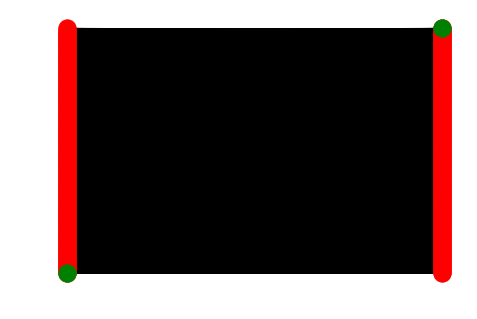

In [143]:
nx.draw(crossbar_graph,pos=pos, node_color='r')
nx.draw_networkx_nodes(crossbar_graph, nodelist=[0,299],pos=pos, node_color='g')


In [144]:
temp=[]
shortestPath_crossbar=[]
onAmp_crossbar=[]

temp=[np.array([0,299])]#.append(getFarthestPairing(nx.adj_matrix(crossbar_graph).todense()))
shortestPath_crossbar=(nx.shortest_path_length(crossbar_graph,temp[0][0],temp[0][1]))
onAmp_crossbar=(shortestPath_crossbar/5)

In [145]:
electrodes=temp

In [146]:
nodesList=[50,100,150,200,250,len(crossbar_graph)]#range(50, len(ws300[i][0])+1,50)

In [147]:
def crossbar_Run(graph,onAmp,nodesList,network,electrodes):
    stimulus=[[],[]]
    dt = 1e-2
    f=0.5
    Time=5
    stimulus[0]=(stimulus__(biasType='AC',onAmp=onAmp,TimeVector=np.arange(0,Time,dt),f=f))
    stimulus[1]=(stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt))) #we don't want this drain to be active during training

    stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item

    results_grid=(runSim(connectivity__(graph=graph),stimulus=stimulus2, contactMode='preSet',electrodes=electrodes[0], T = Time, dt = dt, onAmp = onAmp, biasType='AC',f=f,junctionMode='tunneling'))
#     period=1/f
    
    nwSqu=[None]*len(nodesList)
    countk=0
    for k in nodesList: #loop through sets of nodes for regression     
        print('Running Crossbar Network Regression: ' + str(k) + ' nodes')
        ResultSqu=[]
        ResultSqu = nonLinearTrans(results_grid,'Square',k, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
        nwSqu[countk]=(ResultSqu['accuracy'])
        countk=countk+1
        if k == nodesList[-1]: #if k is equal to the largest node sampling
            network['Accuracy']['Linear Transformation']=[]
            network['Accuracy']['Linear Transformation'].append(nwSqu)
#             print(WS_Grid[i]['Accuracy']['Linear Transformation'])
        else:
            network['Accuracy']['Linear Transformation']=[None]
    
    accNetwork=nwSqu
    return accNetwork,network,results_grid

In [148]:
# results_grid=[]
# results_rand=[]
results=crossbar_Run(crossbar_graph,onAmp_crossbar,nodesList,crossbar,electrodes)

2020-06-17 15:59:36,659:INFO:First current path [0, 299] formed at time = 0.75 s.


Running Crossbar Network Regression: 50 nodes
Running Crossbar Network Regression: 100 nodes
Running Crossbar Network Regression: 150 nodes
Running Crossbar Network Regression: 200 nodes
Running Crossbar Network Regression: 250 nodes
Running Crossbar Network Regression: 300 nodes


In [149]:
junctionsOn=[]
for i in range(len(results[2].junctionSwitch)):
    junctionsOn.append(np.sum(results[2].junctionSwitch[i]))

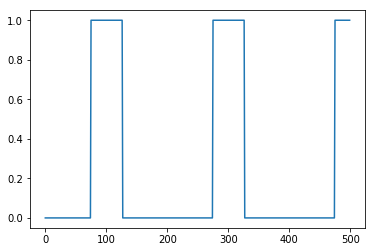

In [150]:
plt.plot(junctionsOn)

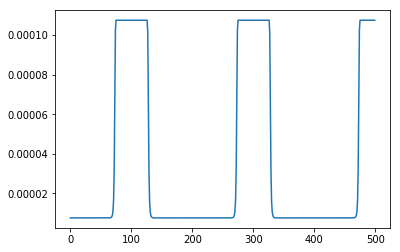

In [151]:
plt.plot(results[2].conductance)

In [152]:
results[0]

[0.6517092682124199,
 0.6517092736439182,
 0.6517092756900961,
 0.6517092748550241,
 0.6517092760040558,
 0.6517092764158053]

In [153]:
crossbar['Accuracy']['Linear Transformation']=results[0]

In [155]:
#export adj matrices to calculate small worldness in matlab:
adj_mats={"AdjMat_bipartite":[]}
adj_mats['AdjMat_bipartite'].append(dict(crossbar=nx.adj_matrix(crossbar_graph).todense()))
crossbar['adj_matrix']=nx.adj_matrix(crossbar_graph).todense()
savemat('/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300_bapartite_AllASN.mat',adj_mats)

In [156]:
# WS:
ci = []
pcoeff= []
mz= []
clustering = []
ci,q=nct.community_louvain(np.squeeze(np.asarray(crossbar['adj_matrix'])))
pcoeff=bct.participation_coef(np.squeeze(np.asarray(crossbar['adj_matrix'])),ci)
mz=bct.module_degree_zscore(np.squeeze(np.asarray(crossbar['adj_matrix'])),ci)
crossbar['G']=crossbar_graph
clustering=nx.clustering(crossbar['G'])
crossbar['Graph Theory']['PL']=dict(nx.all_pairs_shortest_path_length(crossbar['G']))
crossbar['Graph Theory']['Modularity']=ci
crossbar['Graph Theory']['Modularity Score']=q
crossbar['Graph Theory']['PCoeff']=pcoeff
crossbar['Graph Theory']['MZ']=mz
crossbar['Graph Theory']['Small World']=0#smallworld_ba[0][i] #smallworld is 0 from matlab
crossbar['Graph Theory']['CCoeff']=clustering
crossbar['Graph Theory']['Degree']=nx.degree(crossbar['G'])
crossbar['Graph Theory']['AvgPL']=nx.average_shortest_path_length(crossbar['G'])

In [157]:
name='Barpartite_Allnetworks_LinearTransformation.pkl'
print('Saving Barpartite')
with open(name, 'wb') as f:
    pickle.dump([crossbar], f)  

Saving Barpartite
